# Q-Table Learning

In [52]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
import tensorflow as tf

Let's load the Frozen Lake v0 environment

In [136]:
env = gym.make("FrozenLake-v0")

Let's implement the Q-Table algorithm. It's going to be a giant table with all the states as rows and all the actions as columns. Each episode, we are going to update the cell $Q(s,a)$ with the Bellman equation.

$$Q(s,a) = r + \lambda(max(Q(s`, a`))$$

Where s is the current state, a is the current action taken, r is the reward from that action, $\lambda$ is the discount factor of future rewards, \` are the next variables, and $Q(a, b)$ is a lookup in the table.

In [54]:
# Create table with all zeros.
Q = np.zeros([env.observation_space.n, env.action_space.n])

In [55]:
# Learning params
lr = 0.8
y = 0.95
num_episodes = 2000

In [56]:
# Create lists to conatin total rewards and steps per episode
jList = []
rList = []

Lets start the learning!

So for each episode (which is defined by the algorithm running 
until the gym terminates or the number of steps exceeds 99), we 
reset the env to the beginning state and start counting the steps 
and reward.

For each step in a given episode, we calculate the best action by 
finding the max arg in the row, given the state. However, since we 
want to be exploratory at first, we add some noise to all the 
actions. The amount of noise we add decrease with respect to the 
episode we are on.

So the equation we are calculating is given here. 

$$ a = max (a(s) + \frac{u}{1+i})$$

Where $s$ is the current state, $a(s)$ is a function to return a 
vector rewards that could be had if we took the corresponding 
actions, $u$ is a vector of size (1, action_space) with normally 
random numbers, and $i$ is the current episode number. 

With that action, we grab the new state, the reward, and whether or 
not the episode terminated. With the reward, we update Q(s,a) with 
r and the discounted reward of a future action, which also subtract 
our current reward from, because we don't want to double count 
rewards.

We update the total rewards, set the current state as the new 
state, and if the episode terminate, terminate the loop.

In [57]:
for i in xrange(num_episodes):
    s = env.reset() # state
    rAll = 0 # total reward
    d = False # has the episode terminated
    j = 0 # number of steps taken
    while j < 99:
        j += 1
        # Greedily choose an action (with noise) from the table
        a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(1+i)))
        s1, r, d, _ = env.step(a)
        Q[s, a] = Q[s, a] + lr*(r + y*np.max(Q[s1, :]) - Q[s, a])
        rAll += r
        s = s1
        if d:
            break
    jList.append(j)
    rList.append(rAll)

In [58]:
print "Score over time: " + str(sum(rList)/num_episodes)

Score over time: 0.5175


In [59]:
print "Final Q-Table Values"
print Q

Final Q-Table Values
[[  3.85494618e-03   3.41268864e-01   4.52645139e-03   4.71291001e-03]
 [  1.40015285e-03   1.85037900e-03   1.21366832e-03   3.65027778e-02]
 [  1.48788135e-03   1.62231396e-03   1.22524495e-03   1.79664385e-02]
 [  6.59000719e-04   9.77300148e-05   3.11494771e-04   1.05465595e-02]
 [  2.44235959e-01   6.59167097e-04   1.07866355e-03   1.22905816e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  7.84750421e-05   2.22300779e-05   6.93632522e-05   1.34607151e-06]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.70158409e-04   9.81551569e-04   1.06985190e-03   4.38522248e-01]
 [  0.00000000e+00   6.32370679e-01   1.55278079e-03   0.00000000e+00]
 [  1.39581139e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.33447961e-03   2.50408386e-04   8.47552109e-01   3

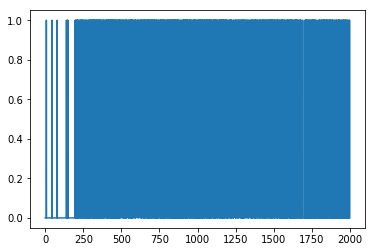

In [60]:
plt.plot(range(2000), rList)
plt.show()

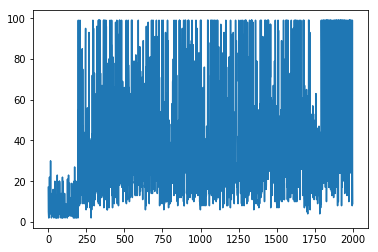

In [61]:
plt.plot(range(2000), jList)
plt.show()

# Q-Network Learning

I am going to implement Q-learning with a neural network instead 
of a table!

We already have the environment loaded, so let's go ahead and make 
the model.

Obviously we need some kind of objective/loss function to update 
the parameters in the network. So we will use the sum of squares 
for the difference between the Q-target and the Q-prediction.

$$ L(\theta) = \sum(Q_t - Q_p)^2 $$

In [165]:
tf.reset_default_graph()
input_size = 16
output_size = 4
lr = 2e-3

Let's make the model!

In [166]:
inputs1 = tf.placeholder(shape=[1,input_size], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01))
Qout = tf.matmul(inputs1, W)
predict = tf.argmax(Qout, 1)

nextQ = tf.placeholder(shape=[1,output_size], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

Let's start training the network, but there are a couple of things here that I need to get straight. 

One is that we are still adding "noise" to our action selection by have a hyperparameter e. If a uniform random number `[0,1)` is below e, then a random action is taken. e is degregaded with respect to the episode number.

$$ e` = \frac{1}{0.02i + 10} $$

And two, we are still performing the Bellman equation, shown above, but in a different way. To train the network, we need a target. The Bellman gives us that target. We take the reward from the action we picked initially (either randomly or by the network), find the next state reward, and then apply the Bellman equation to get a target Q value of our current state! With that in mind, we can update our loss function to something along the lines of this:

$$ L(s, a) = \sum((r + \lambda Q(s`, a`)) - Q(s, a))^2 $$

In [167]:
y = 0.99 # Discounting factor
e = 0.1 # Random chance for random action
num_episodes = 2000
jList = []
rList = []
lList = []

with tf.Session() as sess:
    sess.run(init)
    for i in xrange(num_episodes):
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        lListPre = []
        while j < 99:
            j += 1
            a, allQ = sess.run(
                [predict, Qout],
                feed_dict={inputs1:np.identity(16)[s:s+1]})
            # Grab random action for exploratory reasons!
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            s1, r, d, _ = env.step(a[0])
            Q1 = sess.run(
                Qout, 
                feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0, a[0]] = r+(y*maxQ1) # The target is the reward!
            _, l = sess.run(
                [train_op, loss],
                feed_dict={
                    inputs1:np.identity(16)[s:s+1],
                    nextQ:targetQ})
            rAll += r
            s = s1
            lListPre.append(l)
            if d:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
        lList.append(sum(lListPre))
print "Percent of successful episodes: " + str(sum(rList)/num_episodes) + "%"

Percent of successful episodes: 0.4555%


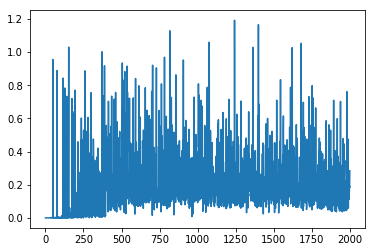

In [168]:
plt.plot(lList)

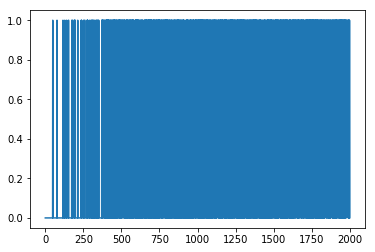

In [169]:
plt.plot(rList)

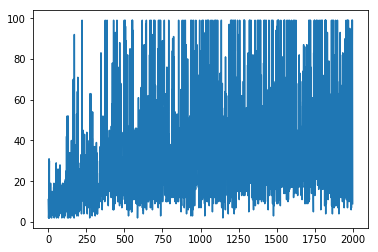

In [170]:
plt.plot(jList)